In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.combine import SMOTETomek
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier


In [2]:
dataset=pd.read_csv(r"C:\Users\rajga\Coding\Final Projects\Diabetes Prediction\diabetes.csv")

In [3]:
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
x=dataset.iloc[:,:-1]

In [6]:
y=dataset["Outcome"]

In [7]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [8]:
sc=StandardScaler()
dataset_scaled=pd.DataFrame(sc.fit_transform(x),columns=x.columns)

In [9]:
dataset_scaled

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496
...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,1.722735,0.870031,0.115169,-0.908682,2.532136
764,-0.547919,0.034598,0.046245,0.405445,-0.692891,0.610154,-0.398282,-0.531023
765,0.342981,0.003301,0.149641,0.154533,0.279594,-0.735190,-0.685193,-0.275760
766,-0.844885,0.159787,-0.470732,-1.288212,-0.692891,-0.240205,-0.371101,1.170732


In [10]:
x_scaled=dataset_scaled

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.94)
x_pca = pca.fit_transform(x_scaled)

In [12]:
smt = SMOTETomek(random_state=42)
x_resampled, y_resampled = smt.fit_resample(x_pca, y)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    x_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [14]:
best_xgb = XGBClassifier(
    learning_rate=0.05,
    n_estimators=400,
    max_depth=20,
    min_child_weight=0.4,
    colsample_bytree=0.6,
    eval_metric='auc',  
    use_label_encoder=False,  
    random_state=42
)


best_xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

C:\Users\rajga\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [10:17:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=0.4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...)

In [15]:
from sklearn.metrics import roc_auc_score

y_proba = best_xgb.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
print("🔥 Final AUC:", round(auc_score, 4))


🔥 Final AUC: 0.9089


📊 Accuracy: 85.05 %
🩺 Recall (Class 1 - Diabetic): 91.75 %
🔥 AUC Score: 0.9089

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84        97
           1       0.81      0.92      0.86        97

    accuracy                           0.85       194
   macro avg       0.86      0.85      0.85       194
weighted avg       0.86      0.85      0.85       194

🔲 Confusion Matrix:
 [[76 21]
 [ 8 89]]


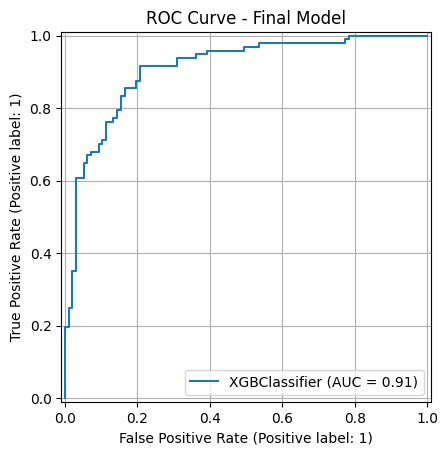

In [16]:
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

y_proba = best_xgb.predict_proba(x_test)[:, 1]


y_pred = (y_proba >= 0.4).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("📊 Accuracy:", round(accuracy * 100, 2), "%")
recall = recall_score(y_test, y_pred)
print("🩺 Recall (Class 1 - Diabetic):", round(recall * 100, 2), "%")
auc = roc_auc_score(y_test, y_proba)
print("🔥 AUC Score:", round(auc, 4))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("🔲 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
RocCurveDisplay.from_estimator(best_xgb, x_test, y_test)
plt.title("ROC Curve - Final Model")
plt.grid(True)
plt.show()


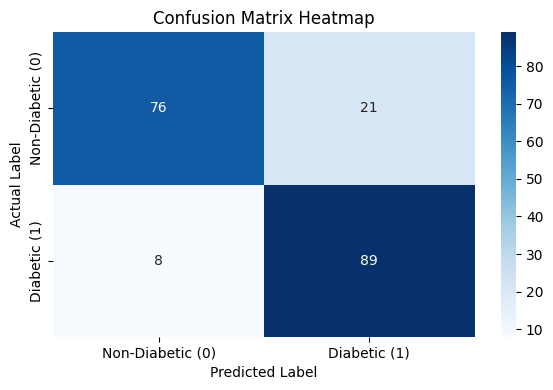

In [17]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Non-Diabetic (0)', 'Diabetic (1)']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()